In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import cm
from tqdm import tqdm
import time
import seaborn as sns

In [3]:
#Data class for fast testing of Gpy

class GPY_data():
    def __init__(self,pdDF,features,cell_lines):
        '''
        Class that takes in dataframe of all the cell conditions and filters for various parameters. Creates sub dataframes by filtering for
        missing gene values, missing protein values and individual chromosome level. Dataframe exists as a 3 column df, to get sub columns of
        the index use:
            #test.rna['AT2_04M_F0'].index.get_level_values(0) #selects a single index for multiindex
        
        self.cell_lines has the names of the different conditions, use that as keys to get data from:
            self.rna - (dictionary) rows of genes of nonzero mRNA levels
            self.rna_protein - (dictinary) rows of genes of nonzero mRNA and protein levels
            self.chrm - (dictionary of dictionary) top level dictionary keys are cell lines, second level down are chrm{i}, 1<=i<=21
        
        Various functions for testing gpy models, and uniform plotting:
            -grid to project back onto chrm position
            -grid 
            
        '''
        assert isinstance(pdDF,pd.DataFrame)
        assert isinstance(features, list)
        assert isinstance(cell_lines, list)
        
        self.data = pdDF.copy() #pandas dataframe
        self.data['Gene Length'] = np.log2(self.data[['Gene Length']]) #log2 of gene length
        self.features = features
        self.cell_lines = cell_lines #single list
        
        self.rna = {} #Dictionary containing dataframe for cell conditions with rows of genes of nonzero mRNA levels
        self.rna_chrm = {} #Dictinoary of data frames filtered for each chromosome, contains all genes with nonzero mRNA
        self.rna_protein = {} #Dictionary containing dataframe for cell conditions with rows of genes of nonzero mRNA and protein levels
        self.rna_protein_chrm = {} #Data frames filtered for each chromosome, contains only nonzero mRNA and protein
        num_chrms = 21 #accounting for both x/y chrms
        
        for cell_condition in cell_lines:
            rna_prot = [cell_condition,cell_condition+'_P'] #mRNA and protein names
            self.rna[cell_condition] = self.data[features+rna_prot][self.data[cell_condition]!=0] #removes genes where mRNA = 0
            self.rna_protein[cell_condition] = self.rna[cell_condition][self.rna[cell_condition][cell_condition+'_P']!=0] #removes genes where mRNA and protein levels are 0
            sub_rna_chrm = {}
            sub_chrm = {}
            for i in range(num_chrms):
                sub_rna_chrm[f'chrm{i+1}'] = self.rna[cell_condition][(self.rna[cell_condition]['AvgChrs']>=i) & (self.rna[cell_condition]['AvgChrs']<i+1)] #filters per chromosome level
                sub_chrm[f'chrm{i+1}'] = self.rna_protein[cell_condition][(self.rna_protein[cell_condition]['AvgChrs']>=i) & (self.rna_protein[cell_condition]['AvgChrs']<i+1)] #filters per chromosome level
            self.rna_chrm[cell_condition] = sub_rna_chrm
            self.rna_protein_chrm[cell_condition] = sub_chrm
                

In [11]:
gp_data = pd.read_csv('Data/GP_data.tsv',sep='\t',index_col=0)
gp_data.set_index(['Gene.names', 'Gene.description'],append=True,inplace=True)

features = ['AvgChrs','NormPosition','Gene Length']
AT2 = ['AT2_04M_F0','AT2_04M_F10','AT2_18M_F0','AT2_18M_F10']
AM = ['AM_04M_F0','AM_04M_F10','AM_18M_F0','AM_18M_F10']
cell_lines = AT2+AM

save=False

data = GPY_data(gp_data,features,cell_lines)

In [10]:
for cell in cell_lines:
    print(len(data.rna[cell]))

13117
13028
12869
13101
11763
11693
11721
11635


In [5]:
for cell in cell_lines:
    print(cell)

AT2_04M_F0
AT2_04M_F10
AT2_18M_F0
AT2_18M_F10
AM_04M_F0
AM_04M_F10
AM_18M_F0
AM_18M_F10


## Histogram of abundance

In [118]:
for cell in cell_lines:
    bins = 50
    matplotlib.rcParams.update({'font.size': 13})
    fig = plt.figure()
    fig.set_size_inches(10,8)
    ax = fig.add_subplot(111)

    #Hist 1
    lbl=f"{len(data.rna[cell][[cell]].values)} detected on transcript"
    ax.hist(data.rna[cell][[cell]].values,bins=bins,color='silver',label=lbl)

    #Hist 2
    non_prot_index = data.rna[cell][cell+'_P']==0
    lbl2 = f"{len(data.rna[cell][cell][non_prot_index].values)} not detected on proteome"
    ax.hist(data.rna[cell][cell][non_prot_index].values,bins=bins,color='dodgerblue',label=lbl2) #Not detected as proteins

    #Hist 3
    lbl3 = f"{len(data.rna_protein[cell][[cell]].values)} detected on both"
    ax.hist(data.rna_protein[cell][[cell]].values,bins=bins,color='blue',label=lbl3) #Detected as proteins


    ax.set_title(f"{cell} Gene Quantification")
    ax.set_xlabel("Log2 TMM Gene Expression")
    ax.set_ylabel("# of genes")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(frameon=False)
    if save == True:
        fig.savefig(f"Quantification/{cell}/{cell}_quant.pdf")
        plt.close()

## Total abundance of all samples to show dynamic range between proteome and transcriptome

In [19]:
matplotlib.rcParams.update({'font.size': 13})
bins=50

for cell in cell_lines:
    fig = plt.figure()
    fig.set_size_inches(8,8)
    ax = fig.add_subplot(111)
    ax.hist(data.rna[cell][[cell]].values,bins=bins,color='blue',label='Transcriptome')
    ax.hist(data.rna_protein[cell][[cell+'_P']].values,bins=bins,color='dimgray',label='Proteome')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(frameon=False)
    ax.set_title('RNA and Protein Abundance Distributions')
    ax.set_xlabel("Log2 Intensity")
    ax.set_ylabel("Counts")
    if save == True:
        fig.savefig(f"Quantification/{cell}/{cell}_protein_rna_quant.pdf")
        plt.close()

In [20]:
matplotlib.rcParams.update({'font.size': 13})
bins=50

for cell in cell_lines:
    fig = plt.figure()
    fig.set_size_inches(8,8)
    ax = fig.add_subplot(111)
    ax.hist(data.rna_protein[cell][[cell]].values,bins=bins,color='blue',label='Transcriptome')
    ax.hist(data.rna_protein[cell][[cell+'_P']].values,bins=bins,color='dimgray',label='Proteome')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(frameon=False)
    ax.set_title('RNA and Protein Abundance Distributions')
    ax.set_xlabel("Log2 Intensity")
    ax.set_ylabel("Counts")
    if save == True:
        fig.savefig(f"Quantification/{cell}/{cell}_protein_rna_quant2.pdf")
        plt.close()

## Scatter plots with gene length

In [26]:
for cell in cell_lines:
    fig = plt.figure()
    fig.set_size_inches(8,8)
    ax = fig.add_subplot(111)
    sc = ax.scatter(data.rna_protein[cell]['Gene Length'],data.rna_protein[cell][cell],c=data.rna_protein[cell][cell+'_P'],cmap = cm.viridis)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title('Protein Intensity vs RNA vs Gene Length')
    ax.set_xlabel("Log2 Gene Length")
    ax.set_ylabel("Log2 TMM Gene Expression")
    plt.colorbar(sc)
    if save == True:
        fig.savefig(f"Quantification/{cell}/{cell}_genelength_rna_protein.pdf")
        plt.close()

## Correlation plots

/gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.war

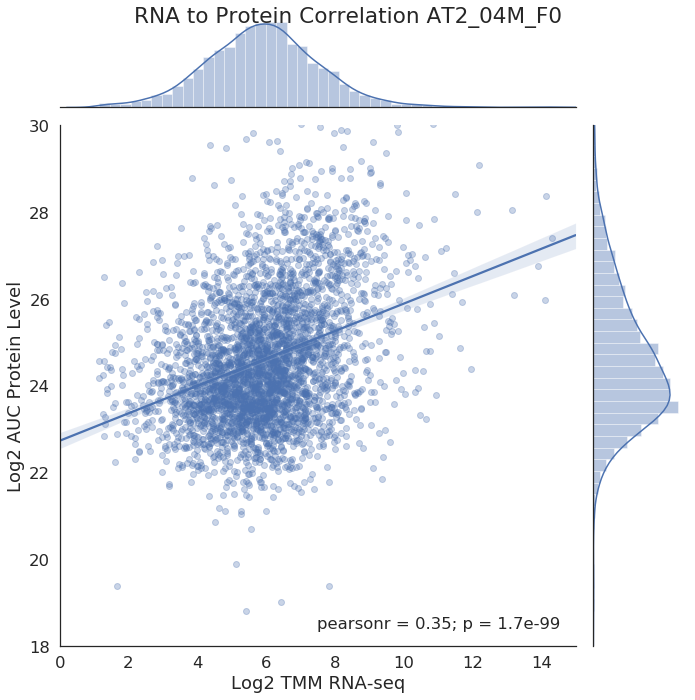

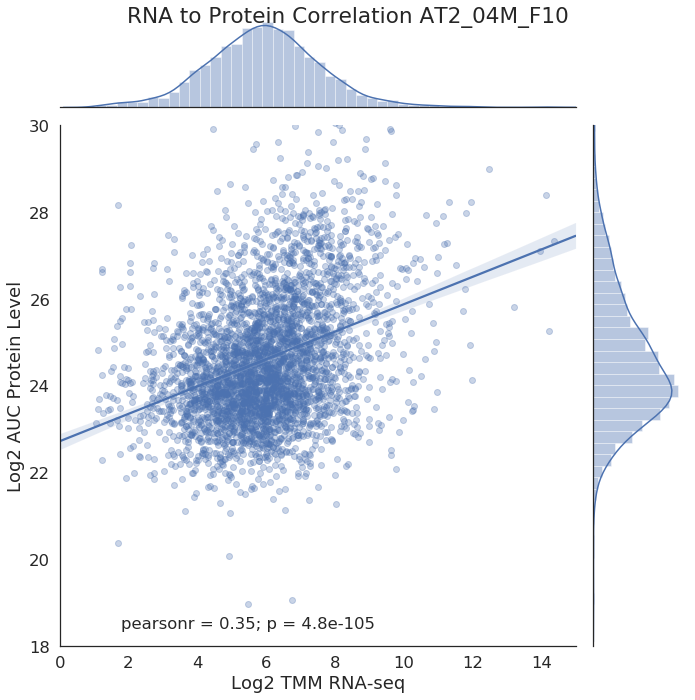

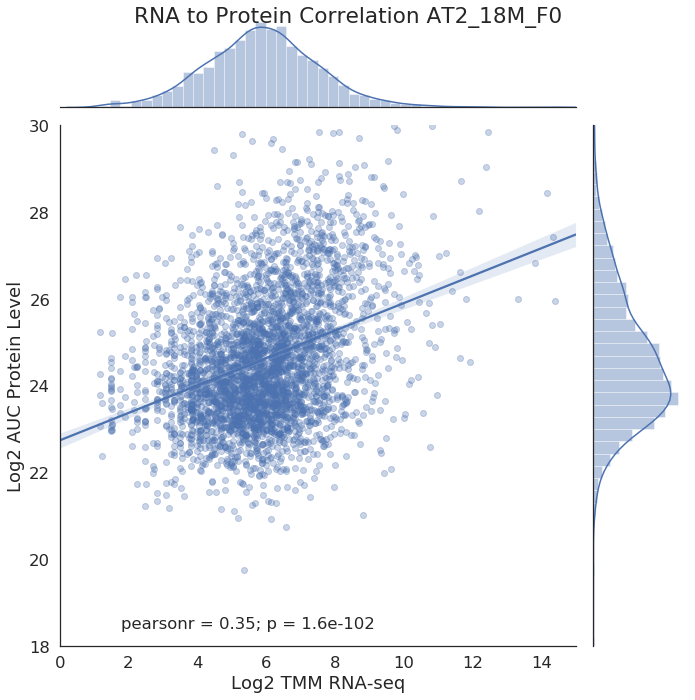

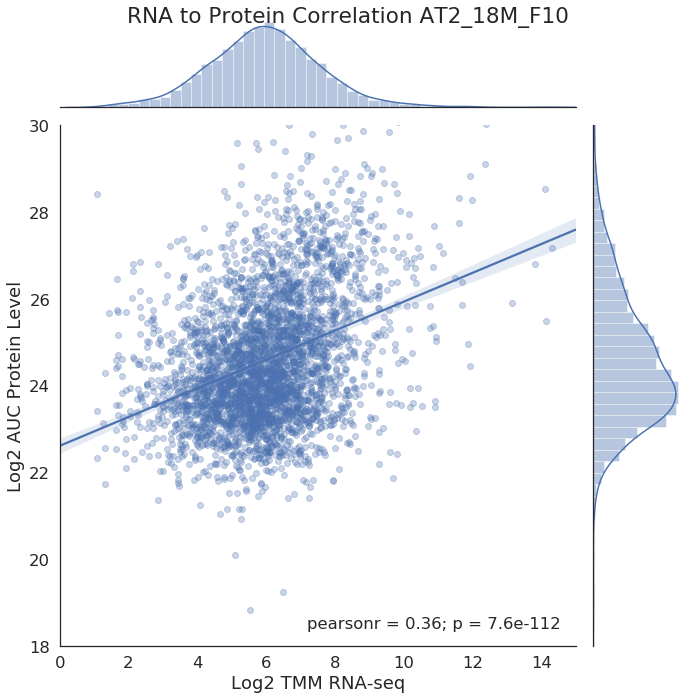

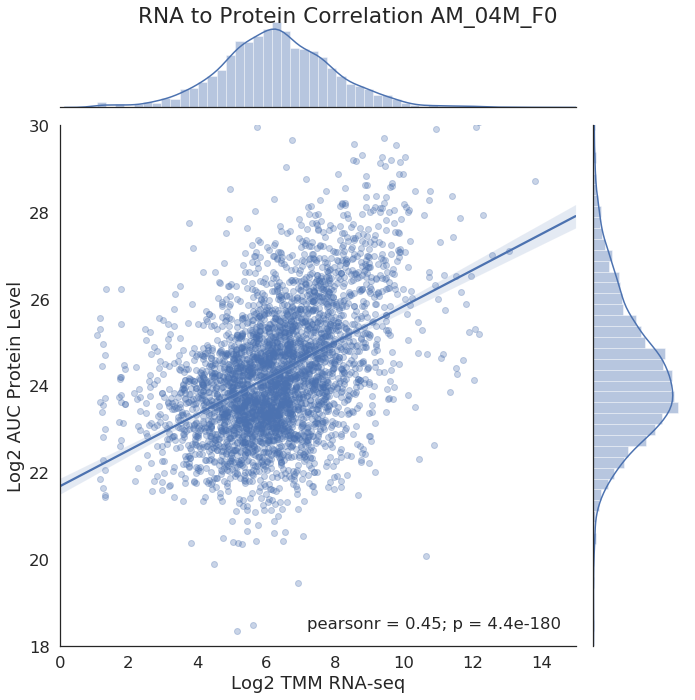

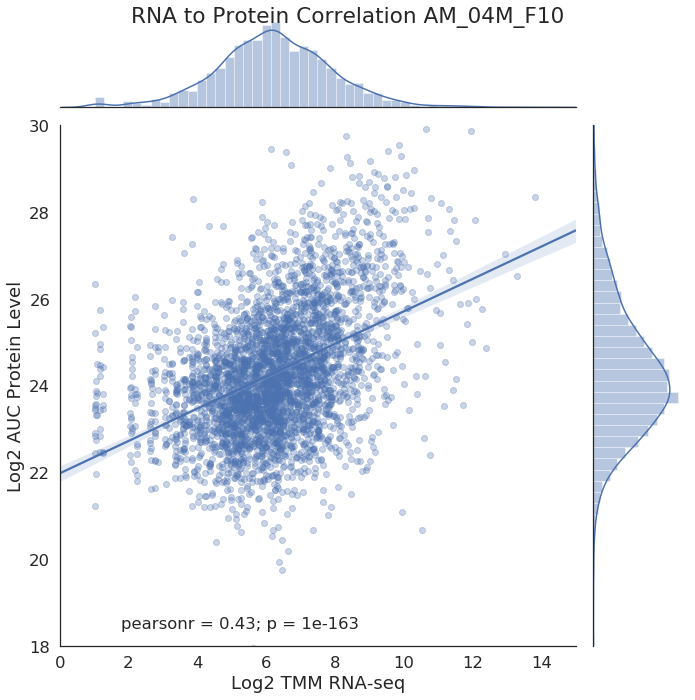

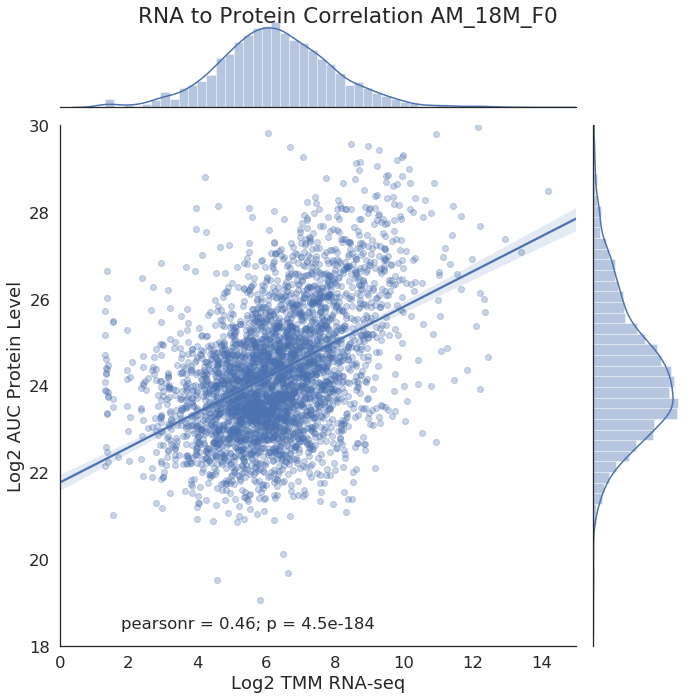

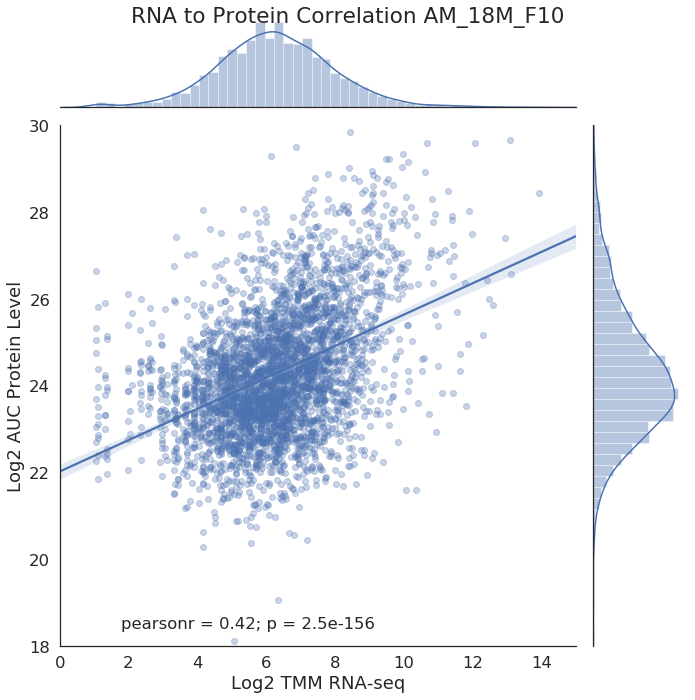

In [27]:
threshold=1
for cell in cell_lines:
    sns.set(style="white", color_codes=True,font_scale=1.5)
    d = data.rna_protein[cell][[cell,cell+'_P']].copy()
    d = d[d[cell]>threshold]
    d.columns = ["Log2 TMM RNA-seq", "Log2 AUC Protein Level"]
    g = sns.jointplot("Log2 TMM RNA-seq", "Log2 AUC Protein Level",data=d,height=10, xlim=(0,15),ylim=(18,30),kind="reg",scatter_kws={'alpha':0.3})
    g.annotate(stats.pearsonr,frameon=False)
    g.fig.suptitle(f"RNA to Protein Correlation {cell}")
    if save == True:
        g.savefig(f'Quantification/{cell}/{cell}_correlation.pdf')
        plt.close()

## Abundance ranking

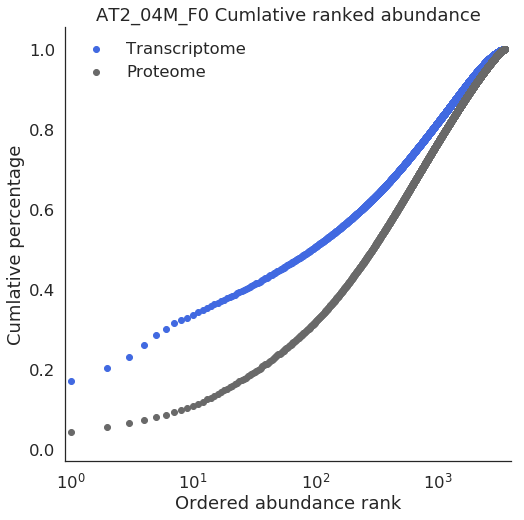

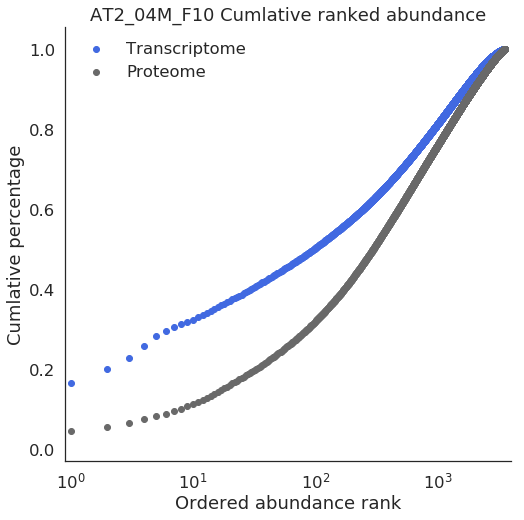

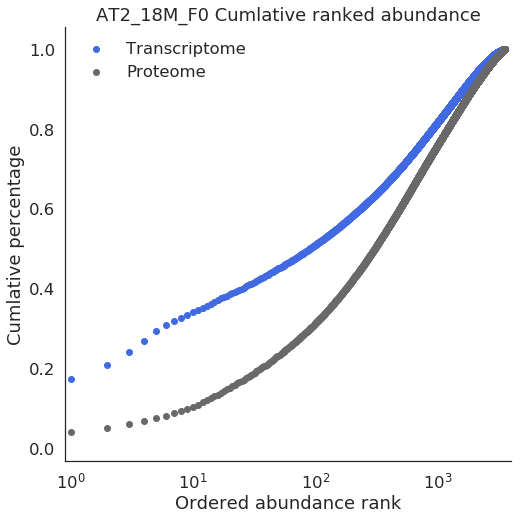

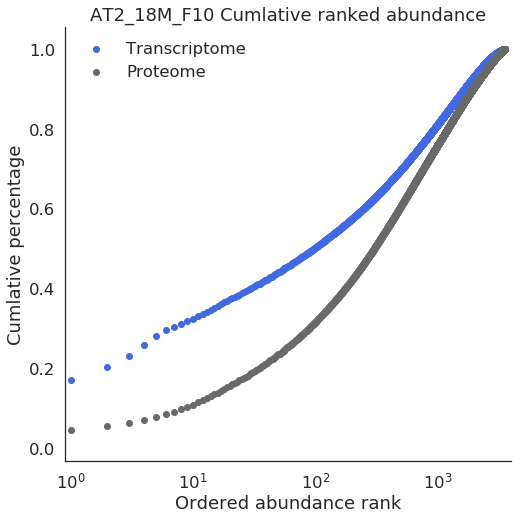

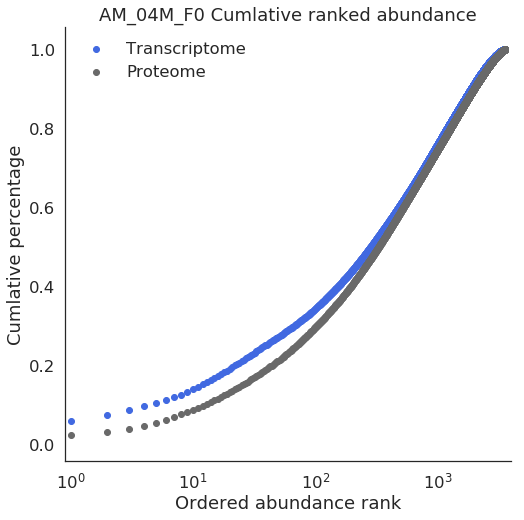

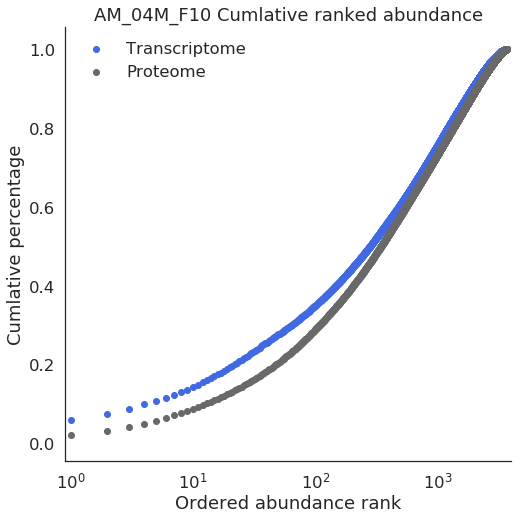

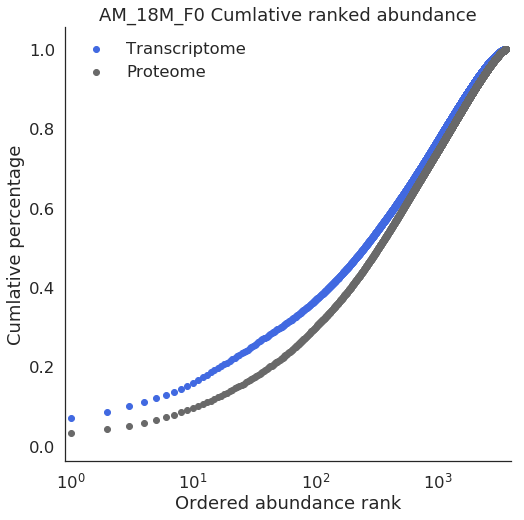

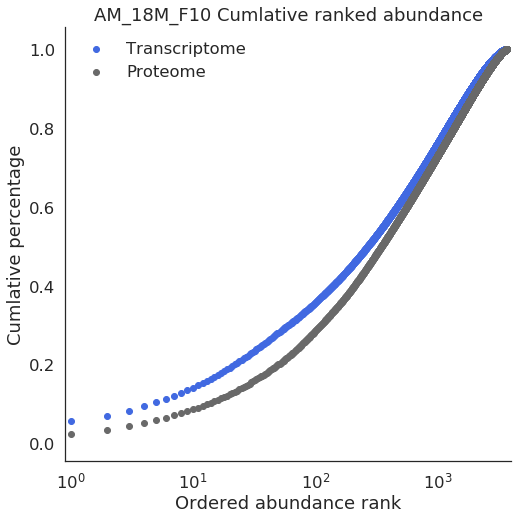

In [28]:
log=2#np.e
matplotlib.rcParams.update({'font.size': 13})
for cell in cell_lines:
    fig = plt.figure()
    fig.set_size_inches(8,8)
    ax = fig.add_subplot(111)
    index = data.rna_protein[cell][[cell]].sort_values(by=[cell], ascending=False).index.get_level_values(1)
    total = (log**data.rna_protein[cell][[cell]]).sum()
    cum_intensity = (log**data.rna_protein[cell][[cell]]).sort_values(by=[cell], ascending=False).cumsum()/total
    cum_intensity.index = index
    cum_intensity = cum_intensity[cell].reset_index()
    sc = ax.scatter(cum_intensity.index,cum_intensity[cell],label='Transcriptome',color='royalblue')


    index = data.rna_protein[cell][[cell+'_P']].sort_values(by=[cell+'_P'], ascending=False).index.get_level_values(1)
    total = (log**data.rna_protein[cell][[cell+'_P']]).sum()
    cum_intensity = (log**data.rna_protein[cell][[cell+'_P']]).sort_values(by=[cell+'_P'], ascending=False).cumsum()/total
    cum_intensity.index = index
    cum_intensity = cum_intensity[cell+'_P'].reset_index()
    sc = ax.scatter(cum_intensity.index,cum_intensity[cell+'_P'],label='Proteome',color='dimgray')

    ax.set_xscale('log')
    ax.set_xlim([0.9, 4000])
    ax.set_title(f"{cell} Cumlative ranked abundance")
    ax.legend(frameon=False)
    ax.set_xlabel("Ordered abundance rank")
    ax.set_ylabel("Cumlative percentage")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if save == True:
        fig.savefig(f"Quantification/{cell}/{cell}_abundance.pdf")
        plt.close()